In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import sys

sys.path.append("../")

In [10]:
import os
import torch

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# sns.set_style("whitegrid")

In [5]:
from pathlib import Path

results_dir = Path(f"../data/results/")

!ls {results_dir}


auroc.json  qa_metrics.json  qa_metrics.tex


In [11]:
import json

with open(results_dir / "qa_metrics.json", "r") as f:
    qa_metrics = json.load(f)

qa_metrics_df = pd.DataFrame(qa_metrics)
qa_metrics_df.head()


,Model,Dataset,Temperature,Prompt,ROUGE-L,Accuracy
0,Llama-3.1-8B-Instruct,NQ-Open,High,Few-Shot,0.23,0.26
1,Llama-3.1-8B-Instruct,NQ-Open,Low,Few-Shot,0.25,0.28
2,Mistral-0.3-7B-Instruct,NQ-Open,High,Few-Shot,0.17,0.19
3,Mistral-0.3-7B-Instruct,NQ-Open,Low,Few-Shot,0.19,0.21
4,Phi-3.5-Mini-Instruct,NQ-Open,High,Few-Shot,0.19,0.24


In [12]:
import json

with open(results_dir / "auroc.json", "r") as f:
    auroc_results = json.load(f)

auroc_df = pd.DataFrame(auroc_results)

In [13]:
auroc_df.head()

,model,prompt,temperature,dataset,metric,auroc,layer
0,Llama-3.1-8B-Instruct,Few-Shot,High,NQ-Open,Diff-eRank,0.756894,1.0
1,Llama-3.1-8B-Instruct,Few-Shot,High,NQ-Open,LogDet,0.594276,1.0
2,Llama-3.1-8B-Instruct,Few-Shot,High,NQ-Open,eRank,0.767473,1.0
3,Llama-3.1-8B-Instruct,Few-Shot,High,NQ-Open,Diff-eRank,0.764786,2.0
4,Llama-3.1-8B-Instruct,Few-Shot,High,NQ-Open,LogDet,0.605132,2.0


In [14]:
auroc_df["prompt"].value_counts()

prompt
Few-Shot           1592
Few-Shot-Trivia     198
Name: count, dtype: int64

<Figure size 6000x3600 with 0 Axes>

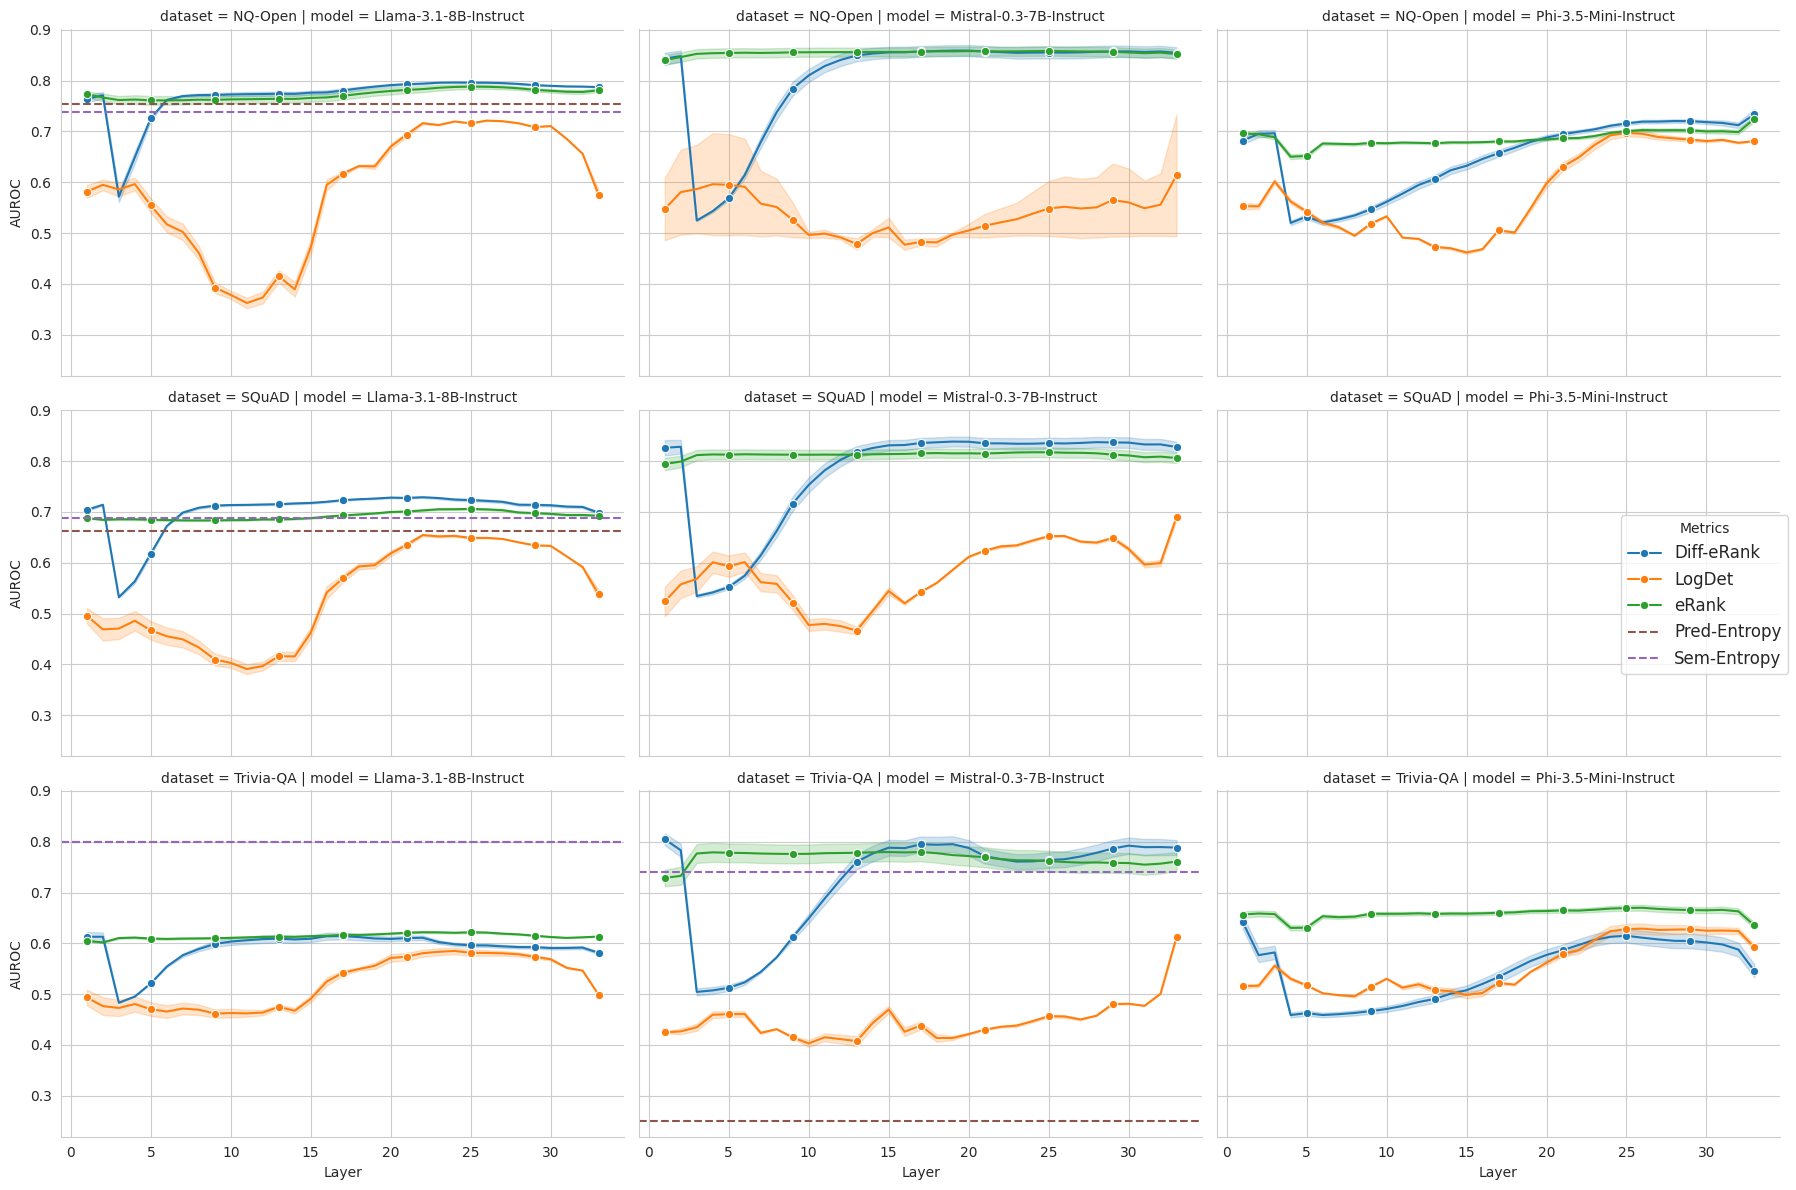

In [15]:
sns.set_style("whitegrid")

df = auroc_df

masks = (
    (df["auroc"] != 0.5) & 
    (df["prompt"] == "Few-Shot") &
    (df["layer"] != np.inf)
)
df_plot = df[masks]

plt.figure(figsize=(20, 12), dpi=300)

g = sns.FacetGrid(
    data=df_plot,
    row="dataset", 
    col="model",
    height=4,
    aspect=1.5
)
g.map_dataframe(
    sns.lineplot,
    x="layer",
    y="auroc",
    hue="metric", 
    marker="o",
    markevery=4
)

# Add horizontal lines for entropy metrics
entropy_colors = {
    "Sem-Entropy": "C4",
    "Pred-Entropy": "C5"
}

# Get entropy metrics data (layer = np.inf)
entropy_df = df[df["layer"] == np.inf].copy()

for i, dataset in enumerate(g.row_names):
    for j, model in enumerate(g.col_names):
        ax = g.axes[i,j]
        
        entropy_vals = entropy_df[
            (entropy_df["dataset"] == dataset) & 
            (entropy_df["model"] == model)
        ]
        
        for _, row in entropy_vals.iterrows():
            ax.axhline(
                y=row["auroc"],
                color=entropy_colors["Sem-Entropy"] if "Sem-Entropy" in row["metric"] else entropy_colors["Pred-Entropy"],
                linestyle="--",
                label=row["metric"]
            )

g.set_axis_labels("Layer", "AUROC")

# Get handles and labels from the first subplot
handles, labels = g.axes[0,0].get_legend_handles_labels()

# Remove duplicate labels while preserving order
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)

# Create a single legend with all metrics
plt.figlegend(
    unique_handles,
    unique_labels,
    loc="center right",
    title="Metrics",
    fontsize=12
)

sns.despine()
g.tight_layout()
plt.savefig("../plots/auroc_by_layer.png", dpi=300, bbox_inches="tight")
plt.show()


In [12]:
auroc_df.head()

,model,prompt,temperature,dataset,metric,auroc,layer
0,Llama-3.1-8B-Instruct,Few-Shot,High,NQ-Open,Diff-eRank,0.756894,1.0
1,Llama-3.1-8B-Instruct,Few-Shot,High,NQ-Open,LogDet,0.594276,1.0
2,Llama-3.1-8B-Instruct,Few-Shot,High,NQ-Open,eRank,0.767473,1.0
3,Llama-3.1-8B-Instruct,Few-Shot,High,NQ-Open,Diff-eRank,0.764786,2.0
4,Llama-3.1-8B-Instruct,Few-Shot,High,NQ-Open,LogDet,0.605132,2.0


In [75]:
last_layer_df = (
    auroc_df.sort_values("layer")
    .groupby(["model", "prompt", "temperature", "dataset", "metric"])
    .last()
    .reset_index()
)
last_layer_df.columns = ["Model", "Prompt", "Temperature", "Dataset", "Metric", "AUROC", "Layer"]

merged_df = pd.merge(
    last_layer_df,
    qa_metrics_df,
    on=['Model', 'Dataset', 'Temperature', 'Prompt'],
    how='inner'
)
assert merged_df.shape[0] == last_layer_df.shape[0]
merged_df.head()

max_last_layer_df = (
    merged_df.groupby(["Dataset", "Model", "Metric"])
    .max()
    .reset_index()
)

max_last_layer_df = max_last_layer_df[["Dataset", "Model", "Metric", "AUROC"]].sort_values(by=["Dataset", "Model", "Metric"])

# Define desired metric order
metric_order = ['eRank', 'Diff-eRank', 'LogDet', 'Pred-Entropy', 'Sem-Entropy']

# Sort max_last_layer_df metrics according to metric_order
max_last_layer_df['Metric'] = pd.Categorical(max_last_layer_df['Metric'], categories=metric_order, ordered=True)
max_last_layer_df = max_last_layer_df.sort_values(['Dataset', 'Model', 'Metric'])

# Create pivot table to show metrics by dataset and model
pivot_df = max_last_layer_df.pivot_table(
    index=["Dataset", "Model"],
    columns="Metric", 
    values="AUROC"
).round(3)

# Add ROUGE-L column from qa_metrics_df
rouge_l_df = qa_metrics_df.groupby(["Dataset", "Model"])["ROUGE-L"].max()
pivot_df["ROUGE-L"] = rouge_l_df

pivot_df = pivot_df.sort_index(level=[0,1])

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(pivot_df)


/tmp/ipykernel_813230/334266276.py:34: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = max_last_layer_df.pivot_table(


Metric                             eRank  Diff-eRank  LogDet  Pred-Entropy  \
Dataset   Model                                                              
NQ-Open   Llama-3.1-8B-Instruct    0.784       0.789   0.585         0.753   
          Mistral-0.3-7B-Instruct  0.861       0.866   0.734           NaN   
          Phi-3.5-Mini-Instruct    0.730       0.744   0.681           NaN   
SQuAD     Llama-3.1-8B-Instruct    0.694       0.701   0.547           NaN   
          Mistral-0.3-7B-Instruct  0.816       0.838   0.697           NaN   
Trivia-QA Llama-3.1-8B-Instruct    0.634       0.618   0.499         0.799   
          Mistral-0.3-7B-Instruct  0.780       0.803   0.615         0.250   
          Phi-3.5-Mini-Instruct    0.641       0.558   0.598           NaN   

Metric                             Sem-Entropy  ROUGE-L  
Dataset   Model                                          
NQ-Open   Llama-3.1-8B-Instruct          0.738     0.25  
          Mistral-0.3-7B-Instruct          NaN     0.19  
          Phi-3.5-Mini-Instruct            NaN     0.21  
SQuAD     Llama-3.1-8B-Instruct            NaN     0.19  
          Mistral-0.3-7B-Instruct          NaN     0.16  
Trivia-QA Llama-3.1-8B-Instruct          0.800     0.59  
          Mistral-0.3-7B-Instruct        0.741     0.46  
          Phi-3.5-Mini-Instruct            NaN     0.46

In [78]:
def format_rouge_l(val):
    return f"{val:.2f}" if pd.notna(val) else "---"

pivot_df["ROUGE-L"] = pivot_df["ROUGE-L"].apply(format_rouge_l)

latex_table = pivot_df.to_latex(
    float_format="%.3f",
    caption="AUROC scores for different metrics across datasets and models",
    label="tab:auroc_scores",
    column_format="llrrrrrr", # Added an extra r for ROUGE-L column
    multicolumn=True,
    multicolumn_format="c",
    bold_rows=True,
    escape=False
)

# Add some latex formatting
latex_table = latex_table.replace("NaN", "---")  # Replace NaN with dashes
latex_table = latex_table.replace("dataset", "Dataset")
latex_table = latex_table.replace("model", "Model")

print(latex_table)

\begin{table}
\caption{AUROC scores for different metrics across Datasets and Models}
\label{tab:auroc_scores}
\begin{tabular}{llrrrrrr}
\toprule
 & Metric & eRank & Diff-eRank & LogDet & Pred-Entropy & Sem-Entropy & ROUGE-L \\
Dataset & Model &  &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{\textbf{NQ-Open}} & \textbf{Llama-3.1-8B-Instruct} & 0.784 & 0.789 & 0.585 & 0.753 & 0.738 & 0.25 \\
\textbf{} & \textbf{Mistral-0.3-7B-Instruct} & 0.861 & 0.866 & 0.734 & --- & --- & 0.19 \\
\textbf{} & \textbf{Phi-3.5-Mini-Instruct} & 0.730 & 0.744 & 0.681 & --- & --- & 0.21 \\
\cline{1-8}
\multirow[t]{2}{*}{\textbf{SQuAD}} & \textbf{Llama-3.1-8B-Instruct} & 0.694 & 0.701 & 0.547 & --- & --- & 0.19 \\
\textbf{} & \textbf{Mistral-0.3-7B-Instruct} & 0.816 & 0.838 & 0.697 & --- & --- & 0.16 \\
\cline{1-8}
\multirow[t]{3}{*}{\textbf{Trivia-QA}} & \textbf{Llama-3.1-8B-Instruct} & 0.634 & 0.618 & 0.499 & 0.799 & 0.800 & 0.59 \\
\textbf{} & \textbf{Mistral-0.3-7B-Instruct} & 0.780 & 0.803 & 0.615 & 0.25

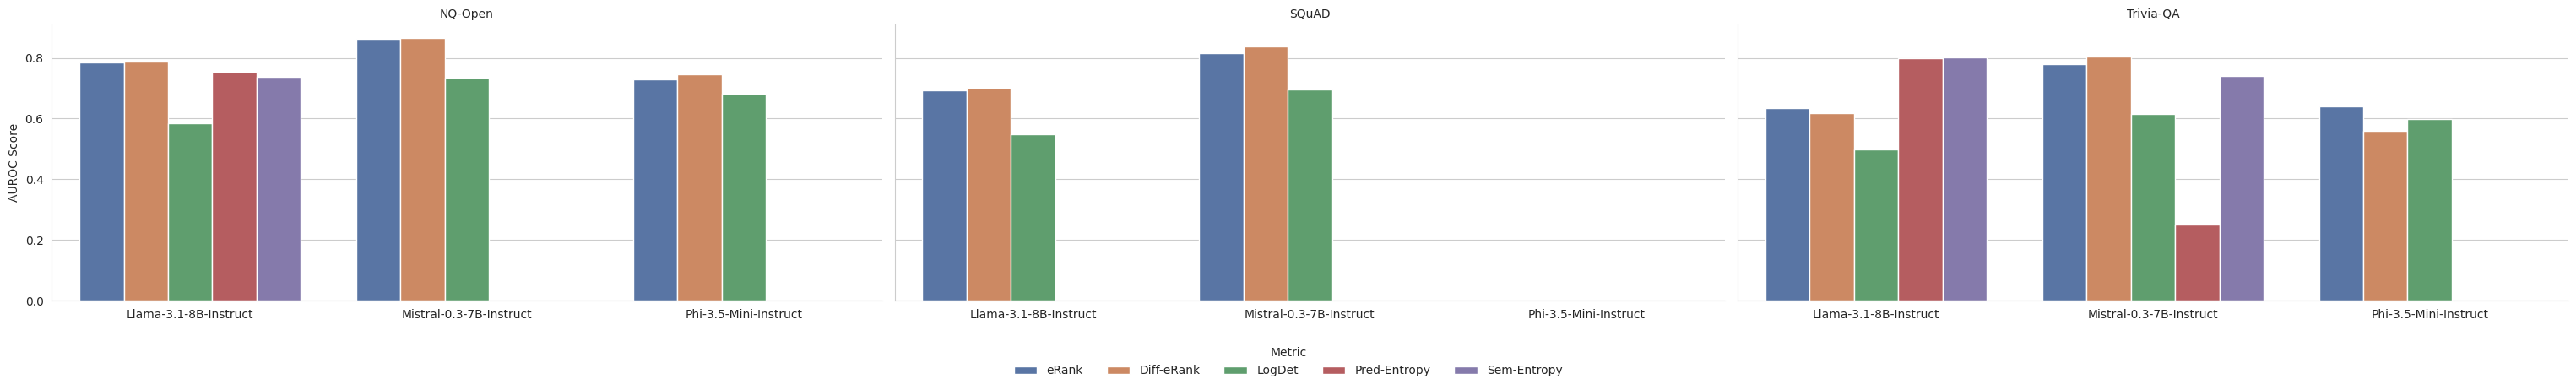

In [82]:
metric_order = ['eRank', 'Diff-eRank', 'LogDet', 'Pred-Entropy', 'Sem-Entropy']

g = sns.FacetGrid(
    max_last_layer_df,
    col='Dataset', 
    height=4,
    aspect=2
)
g.map_dataframe(
    sns.barplot,
    x='Model',
    y='AUROC', 
    hue='Metric',
    hue_order=metric_order,
    palette='deep'
)

# Set titles and labels for the plot
g.set_titles(col_template='{col_name}')
g.set_axis_labels('', 'AUROC Score')
g.add_legend(title='Metric', bbox_to_anchor=(0.5, -0.01), loc='upper center', ncol=5)

plt.tight_layout()
plt.savefig("../plots/max_auroc_barplot.png", dpi=300, bbox_inches="tight")

plt.show()


# TODO: Add attention score

In [40]:
# metric = "attn_score"

# dfs = []

# for results in ...:
#     # Create dataframe from results
#     results_df = pd.DataFrame(results["results_all"])

#     # Load and process attention scores
#     attn_path = Path("/data/hallucinations/activations/nq_open/llama_3.1_8b_instruct/sampling_high_temp_with_activations_and_attentions__prompt_qa_short_few_shot_sep__seed_42/log_det_attn.pt")

#     atn_scores = torch.load(attn_path)
#     atn_scores = torch.stack(atn_scores).sum(dim=2).to(torch.float32)
